In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymc3 import Normal, Model, HalfNormal, Uniform, Deterministic, sample_prior_predictive, math, plot_trace
from pymc3_ext.distributions import Angle
from astropy.io import ascii
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u
from chromatic import *
import numpy as np
import astrotools.orbitparams as orb

In [2]:
sample = ascii.read('sample_final.csv')

In [3]:
ind = np.argwhere(sample['pl_name']=='GJ 3473 b')
sample['pl_orbeccen'][ind] = 0.1
ind = np.argwhere(sample['pl_name']=='GJ 357 b')
sample['pl_orbeccen'][ind] = 0.09
ind = np.argwhere(sample['pl_name']=='LHS 1478 b')
sample['pl_orbeccen'][ind] = 0.1
ind = np.argwhere(sample['pl_name']=='TOI-1468 b')
sample['pl_orbeccen'][ind] = 0.1
ind = np.argwhere(sample['pl_name']=='LHS 1140 c')
sample['pl_orbeccen'][ind] = 0.068
ind = np.argwhere(sample['pl_name']=='L 98-59 c')
sample['pl_orbeccen'][ind] = 0.05  # upper limit from stability arguments is 0.07 (Cloutier+ 2019)
ind = np.argwhere(sample['pl_name']=='TOI-270 b')
sample['pl_orbeccen'][ind] = 0.0167 # from dynamical analysis ()


sample['pl_ecosw']    = [0.000 for i in sample]
sample['pl_ecoswerr'] = [0.0500 for i in sample]

ind = np.argwhere(sample['pl_name']=='LHS 1478 b')
sample['pl_ecosw'][ind] = 0.065
sample['pl_ecoswerr'][ind] = 0.073

sample['pl_name', 'pl_tranmid', 'pl_tranmiderr1', 'pl_orbper', 'pl_orbpererr1', 'pl_orbeccen', 'pl_ecosw', 'pl_ecoswerr']

pl_name,pl_tranmid,pl_tranmiderr1,pl_orbper,pl_orbpererr1,pl_orbeccen,pl_ecosw,pl_ecoswerr
str11,float64,float64,float64,float64,float64,float64,float64
GJ 3473 b,2458492.20412163,0.00037015,1.198003975976397,5.76582216e-07,0.1,0.0,0.05
GJ 357 b,2458517.998679131,0.0003765,3.9306063296116895,1.16151077e-06,0.09,0.0,0.05
HD 260655 b,2459497.9102,0.0003,2.76953,3e-05,0.039,0.0,0.05
L 98-59 c,2458367.27375,0.00013,3.6906777,1.6e-06,0.05,0.0,0.05
LHS 1140 c,2458389.2942323,0.00062395,3.777939728,5.83523921e-06,0.068,0.0,0.05
LHS 1478 b,2458786.75425,0.00042,1.9495378,4e-06,0.1,0.065,0.073
LTT 3780 b,2458543.91281,0.00048,0.768377,1.4e-06,0.064,0.0,0.05
TOI-1468 b,2458765.68079,0.0007,1.8805136,2.4e-06,0.1,0.0,0.05
TOI-270 b,2458387.09505,0.00074,3.3601538,4.8e-06,0.0167,0.0,0.05


In [4]:
sample[1]

hostname,pl_name,sy_dist,rastr,decstr,sy_kmag,st_mass,st_rad,st_raderr1,st_raderr2,st_teff,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbsmax,pl_orbincl,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,tran_flag,rv_flag,pl_rp_rs,pl_g,pl_teq_a0,pl_s,pl_rho,filter,subarray,nobs,ngroup,frac_fullwell,pl_ecosw,pl_ecoswerr
str9,str11,float64,str12,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,str6,str6,int64,int64,float64,float64,float64
GJ 357,GJ 357 b,9.44181,09h36m01.79s,-21d39m54.23s,6.475,0.34,0.34,0.02,-0.02,3505.0,2458517.998679131,0.0003765,-0.0003765,1.217,0.084,-0.083,1.84,0.31,-0.31,3.9306063296116895,1.16151077e-06,-1.16151077e-06,0.035,89.12,0.09,--,--,1,1,0.03281564780289002,12.17283537042799,526.7769415618036,12.786873373040743,5.609388414817885,f1500w,sub64,1,22,0.85,0.0,0.05


In [5]:
def calc_eclipse_timing(targ, use_ecosw=False, Nsamp=10000):

    assumptions = {}

    P_mu    = targ['pl_orbper']
    P_sig   = np.mean([targ['pl_orbpererr1'], abs(targ['pl_orbpererr2'])])
    Tc_mu   = targ['pl_tranmid']
    Tc_sig  = np.mean([targ['pl_tranmiderr1'], abs(targ['pl_tranmiderr2'])])
    e_guess = targ['pl_orbeccen'] #+ targ['pl_orbeccenerr1'].value[0][0]
    ecosw_guess = [targ['pl_ecosw'], targ['pl_ecoswerr']]
    
    with Model() as model:
        P = Normal('P', mu=P_mu, sigma=P_sig)
        Tc = Normal('Tc', mu=Tc_mu, sigma=Tc_sig)
        if use_ecosw:
            ecosw = Normal('ecosw', mu=ecosw_guess[0], sigma=ecosw_guess[1])
        else: 
            e = HalfNormal('e', sigma=e_guess/2)
            w = Uniform('w', -np.pi, np.pi)
            ecosw = Deterministic('ecosw', e*math.cos(w))
        dt = Deterministic('dt', P/2*(4/np.pi*ecosw))
        from_paper = sample_prior_predictive(Nsamp)
    assumptions[f'Literature RV measurement $e={e_guess}$ (95%) and uniform $\omega$'] = from_paper
    
    # picking an orbit number in the near future
    orbit_number = np.median(np.round((Time('2024-01-01').jd - from_paper['Tc'])/from_paper['P']))
    predicted_transit_time = from_paper['P']*orbit_number + from_paper['Tc']
    print(f'The uncertainty on predicted transit times in 2024 = {np.std(predicted_transit_time)*24*60} minutes')
    
    return assumptions

In [6]:
def calc_window(targ, t_settle=0.5*u.hour, t_flex=1*u.hour, ntimeseclipsedur=1, t_extra=1*u.hour):
    """
    JWST Docs recommends t_settle = 30 minutes
    JWST APT will charge overhead of 1 hour if you have too small a starting window; 
             charge this to yourself with t_flex=1 hour
    """
    tdur = orb.Tdur(P=targ['pl_orbper']*u.day, 
                Rp_Rs=((targ['pl_rade']*u.R_earth)/(targ['st_rad']*u.R_sun)).decompose(),
                a_Rs = ((targ['pl_orbsmax']*u.AU)/(targ['st_rad']*u.R_sun)).decompose(),
                i = targ['pl_orbincl']
               ) # event duration
    print('event duration:', tdur.to(u.hour))
    
    if targ['pl_orbper'] > 3 and targ['pl_orbeccen'] > 0.05:
        # worst case scenario
        ntimeseclipsedur = 2
        print(f'padding baseline for orbital period >3 days and ecc >= 0.05/ Tfrac={ntimeseclipsedur}')
    elif targ['pl_orbper'] > 1.5 and targ['pl_orbeccen'] >= 0.05:
        ntimeseclipsedur = 1.2
        print(f'padding baseline for orbital period >2 days and ecc >= 0.05/ Tfrac={ntimeseclipsedur}')   
    
    t_settle = t_settle
    t_eclipse = tdur.to(u.hour)
    t_flex = t_flex
    t_out_of_eclipse = t_eclipse*ntimeseclipsedur
    t_extra = t_extra


    windows = {}
    duration_without_extra = (t_settle + t_eclipse + t_out_of_eclipse + t_flex)
    start, stop = (-duration_without_extra/2).value, (duration_without_extra/2).value
    windows[f'try1'] = start, stop, t_flex
    #start, stop = (-duration_without_settle/2 - t_settle).value, (duration_without_settle/2).value
    #windows[f'with settling {t_settle:.1f}'] = start, stop
    duration_with_extra = duration_without_extra + t_extra
    start, stop = (-duration_with_extra/2).value, (duration_with_extra/2).value
    windows[f'with extra {t_extra:.1f}'] = start, stop, t_flex
    duration_with_more_extra = duration_with_extra + t_extra
    start, stop = (-duration_with_more_extra/2).value, (duration_with_more_extra/2).value
    windows[f'with more extra {t_extra:.1f}'] = start, stop, t_flex
    
    return windows

Make sure that the propagated mid-time from the ephemeris is still small:

In [7]:
def make_eclipse_timing_fig(pl_name, assumptions, windows, savefig=False):
    fi, ax = plt.subplots(len(assumptions), 1, figsize=(12, 4*len(assumptions)), constrained_layout=True, dpi=600)
    if len(assumptions)==1: ax=[ax]
    for (t, d), a in zip(assumptions.items(), ax):
        dt_hours = d['dt']*24
        plt.sca(a)
        plt.hist(dt_hours, bins=np.linspace(-24,24,48*60), density=True, label='possible mid-eclipse offsets', color='silver');

        for (label, (start, stop, t_flex)), color in zip(windows.items(), ['indigo', 'crimson', 'orangered', 'gold']):
            best_offset_from_zero = 0
            fraction_within_exact = 0 
            for offset_from_zero in np.linspace(-4,4):
                this_fraction_within_exact = np.sum((dt_hours >= (start + offset_from_zero))  & (dt_hours <= (stop + offset_from_zero)))/len(dt_hours)
                if this_fraction_within_exact > fraction_within_exact:
                    best_offset_from_zero = offset_from_zero
                    fraction_within_exact = this_fraction_within_exact       
            start += best_offset_from_zero
            stop += best_offset_from_zero
            fractions_within_possible = []
            for i in range(100):
                nudge = np.random.uniform(-t_flex.value/2, t_flex.value/2)
                possible_start, possible_stop = start + nudge, stop + nudge 
                f = np.sum((dt_hours >= possible_start)  & (dt_hours <= possible_stop))/len(dt_hours)
                fractions_within_possible.append(f)
            average_fraction = np.mean(fractions_within_possible)
            sigma_fraction = np.std(fractions_within_possible)
            print(f"""
                   With the assumption of ''{t}', 
                   and the '{label}' observing window option, 
                   The best offset from exactly 0.5 phase is {best_offset_from_zero:.2f} hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of {fraction_within_exact:.2%}.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of {average_fraction:.2%} +/- {sigma_fraction:.2%}
                   """)    
            plt.axvspan(start, stop, alpha=0.1, color=color, label=label + f' (={stop-start}h) = {average_fraction:.2%}')

        plt.title(t)
        plt.legend(frameon=False, bbox_to_anchor=(1,1))
        plt.xlim(-12, 12)
        plt.grid(alpha=0.4)
        plt.xlabel('Mid-Eclipse Offset from Phase 0.5 (hours)')
        plt.suptitle(f'{pl_name}: Probability of Observing Mid-Eclipse, Given Different Eccentricity Assumptions + Window Constraints');
        if savefig: plt.savefig(f'../sample/eclipse_timing/{pl_name}-eclipse-timing-constraints.png')
        plt.show()

In [8]:
#targ = sample[0]
#if targ['pl_orbeccen'] == 0.0: targ['pl_orbeccen'] = 0.05
#print(targ['pl_name'], 'P =', targ['pl_orbper'], 'days', 'ecc =', targ['pl_orbeccen'])
#assumptions = calc_eclipse_timing(targ)
#windows = calc_window(targ, t_extra=1*u.hour)
#make_eclipse_timing_fig(targ['pl_name'].replace(" ", ""), assumptions, windows)

GJ 3473 b P = 1.198003975976397 days ecc = 0.1
The uncertainty on predicted transit times in 2024 = 1.3572707315573287 minutes
event duration: 0.9421815402185265 h

                   With the assumption of ''Literature RV measurement $e=0.1$ (95%) and uniform $\omega$', 
                   and the 'try1' observing window option, 
                   The best offset from exactly 0.5 phase is -0.08 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 97.78%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 97.17% +/- 0.65%
                   

                   With the assumption of ''Literature RV measurement $e=0.1$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
                   The best offset from exactly 0.5 phase is -0.08 hours.
         

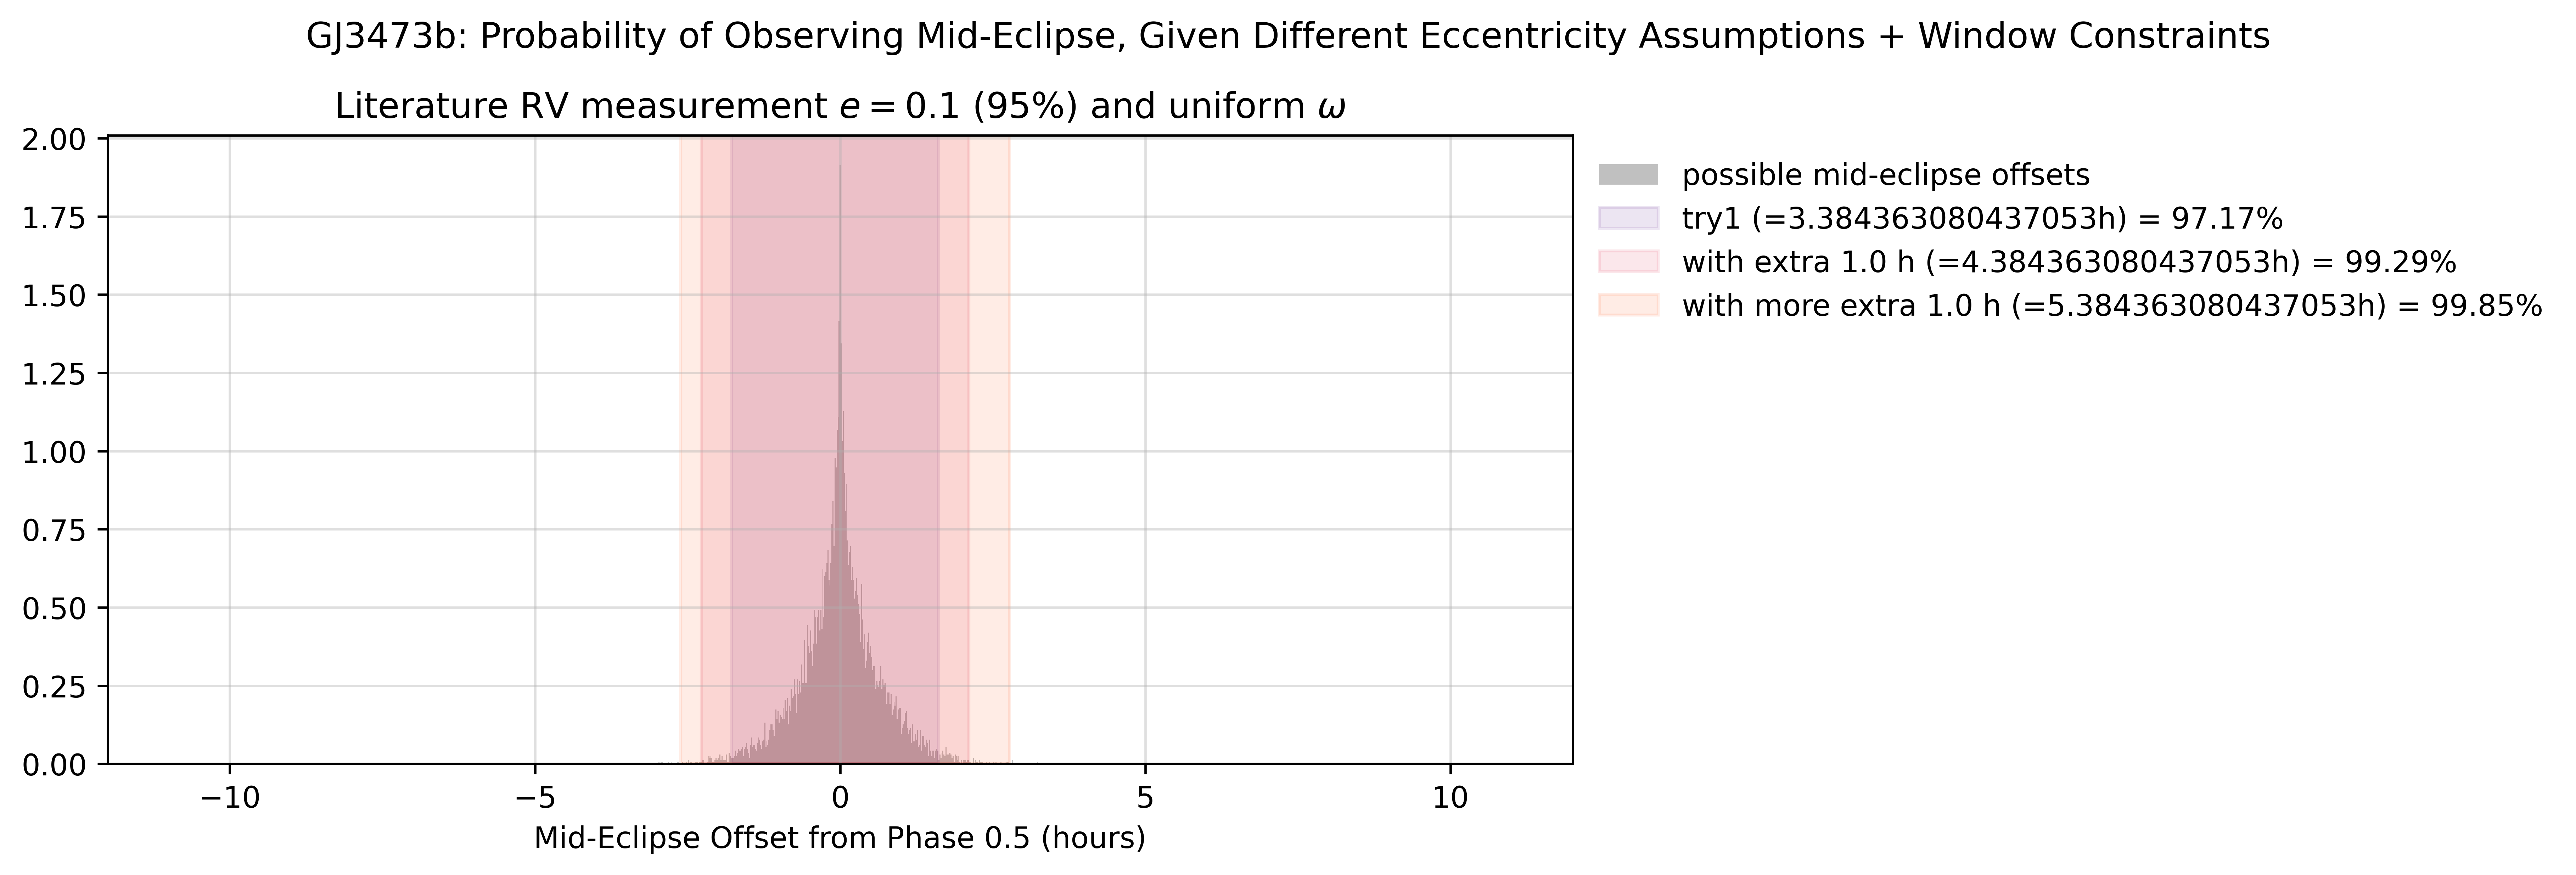

GJ 357 b P = 3.9306063296116895 days ecc = 0.09
The uncertainty on predicted transit times in 2024 = 0.9289060400524726 minutes
event duration: 1.3235503775300512 h
padding baseline for orbital period >3 days and ecc >= 0.05/ Tfrac=2

                   With the assumption of ''Literature RV measurement $e=0.09$ (95%) and uniform $\omega$', 
                   and the 'try1' observing window option, 
                   The best offset from exactly 0.5 phase is 0.08 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 84.81%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 84.45% +/- 0.40%
                   

                   With the assumption of ''Literature RV measurement $e=0.09$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
            

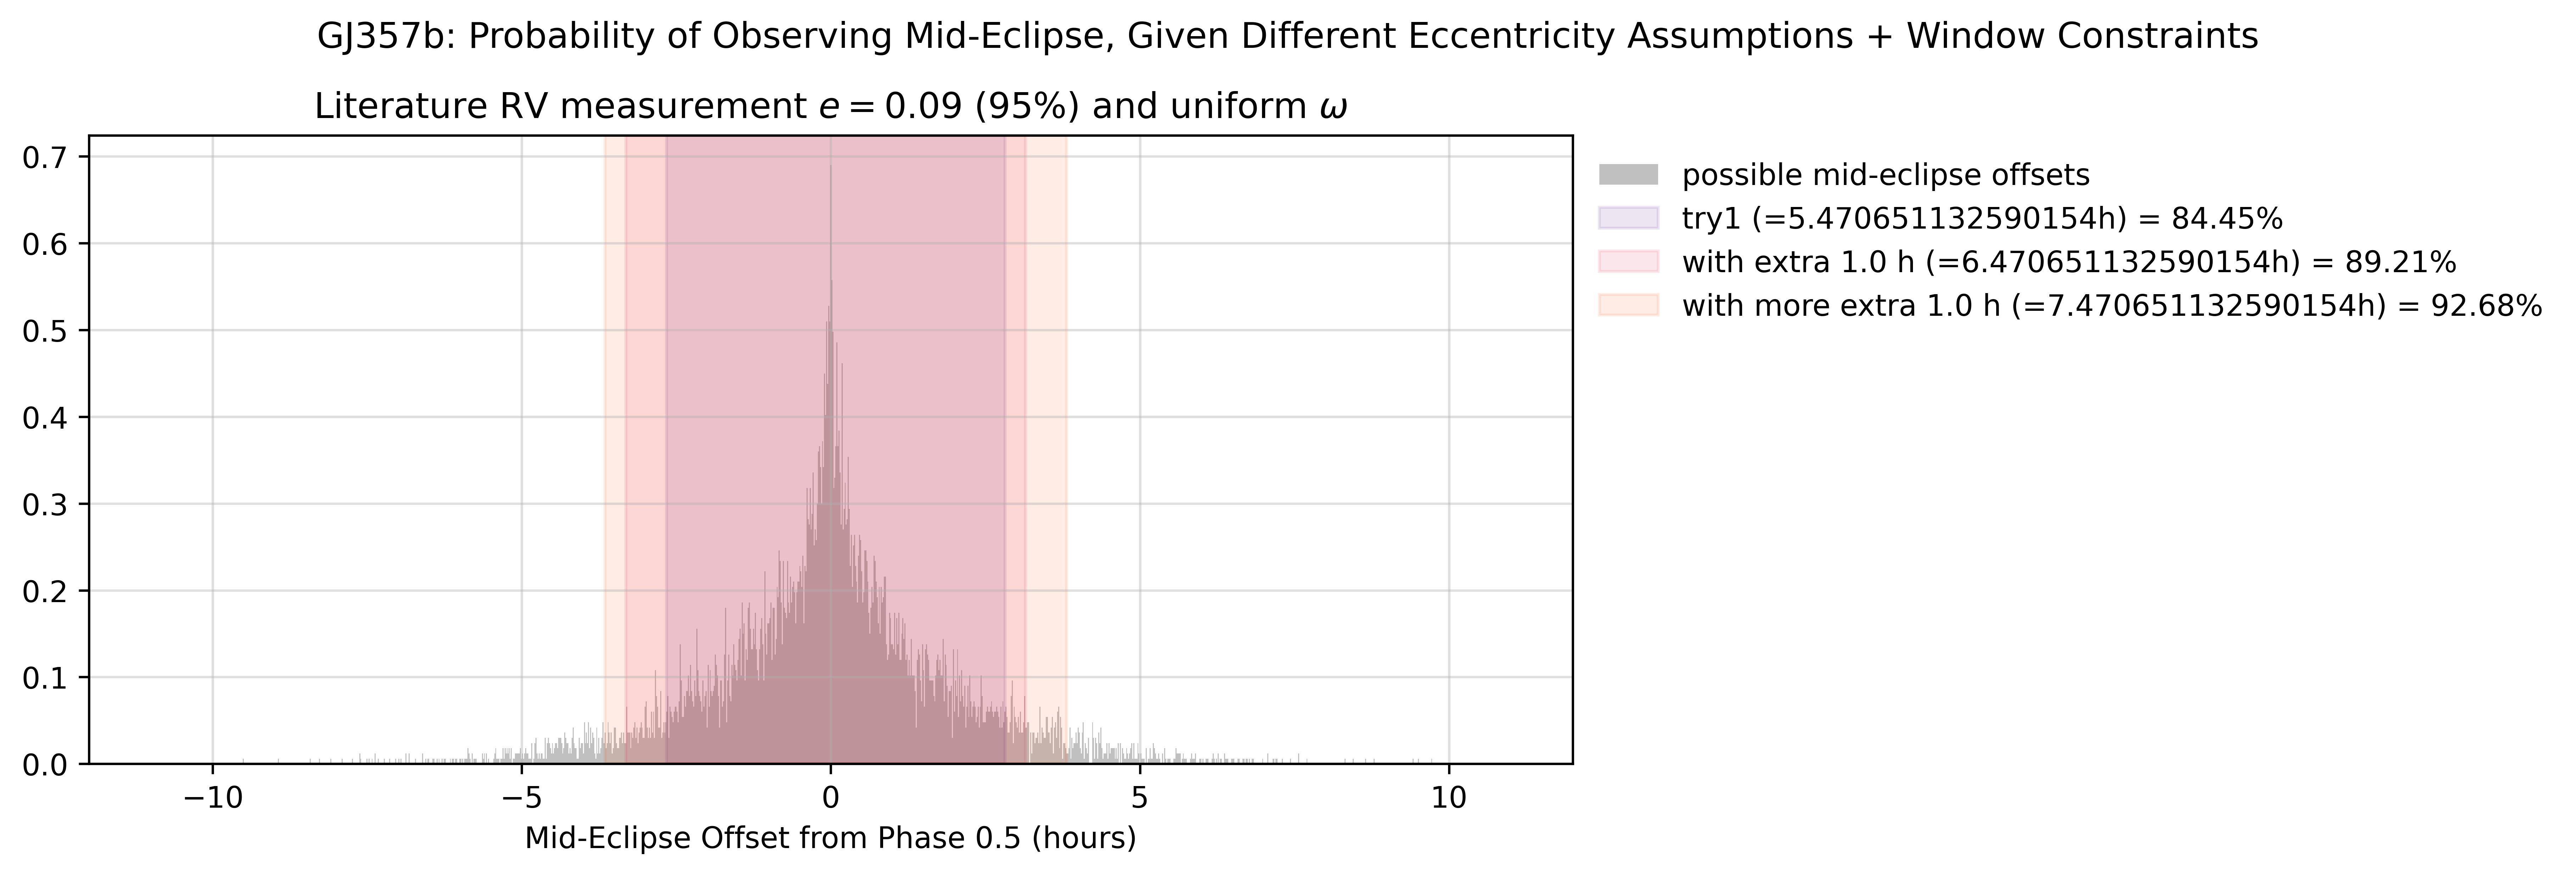

HD 260655 b P = 2.76953 days ecc = 0.039
The uncertainty on predicted transit times in 2024 = 12.748728833037164 minutes
event duration: 1.1532108714669438 h

                   With the assumption of ''Literature RV measurement $e=0.039$ (95%) and uniform $\omega$', 
                   and the 'try1' observing window option, 
                   The best offset from exactly 0.5 phase is 0.08 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 99.41%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 99.12% +/- 0.29%
                   

                   With the assumption of ''Literature RV measurement $e=0.039$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
                   The best offset from exactly 0.5 phase is 0.08 hours.
             

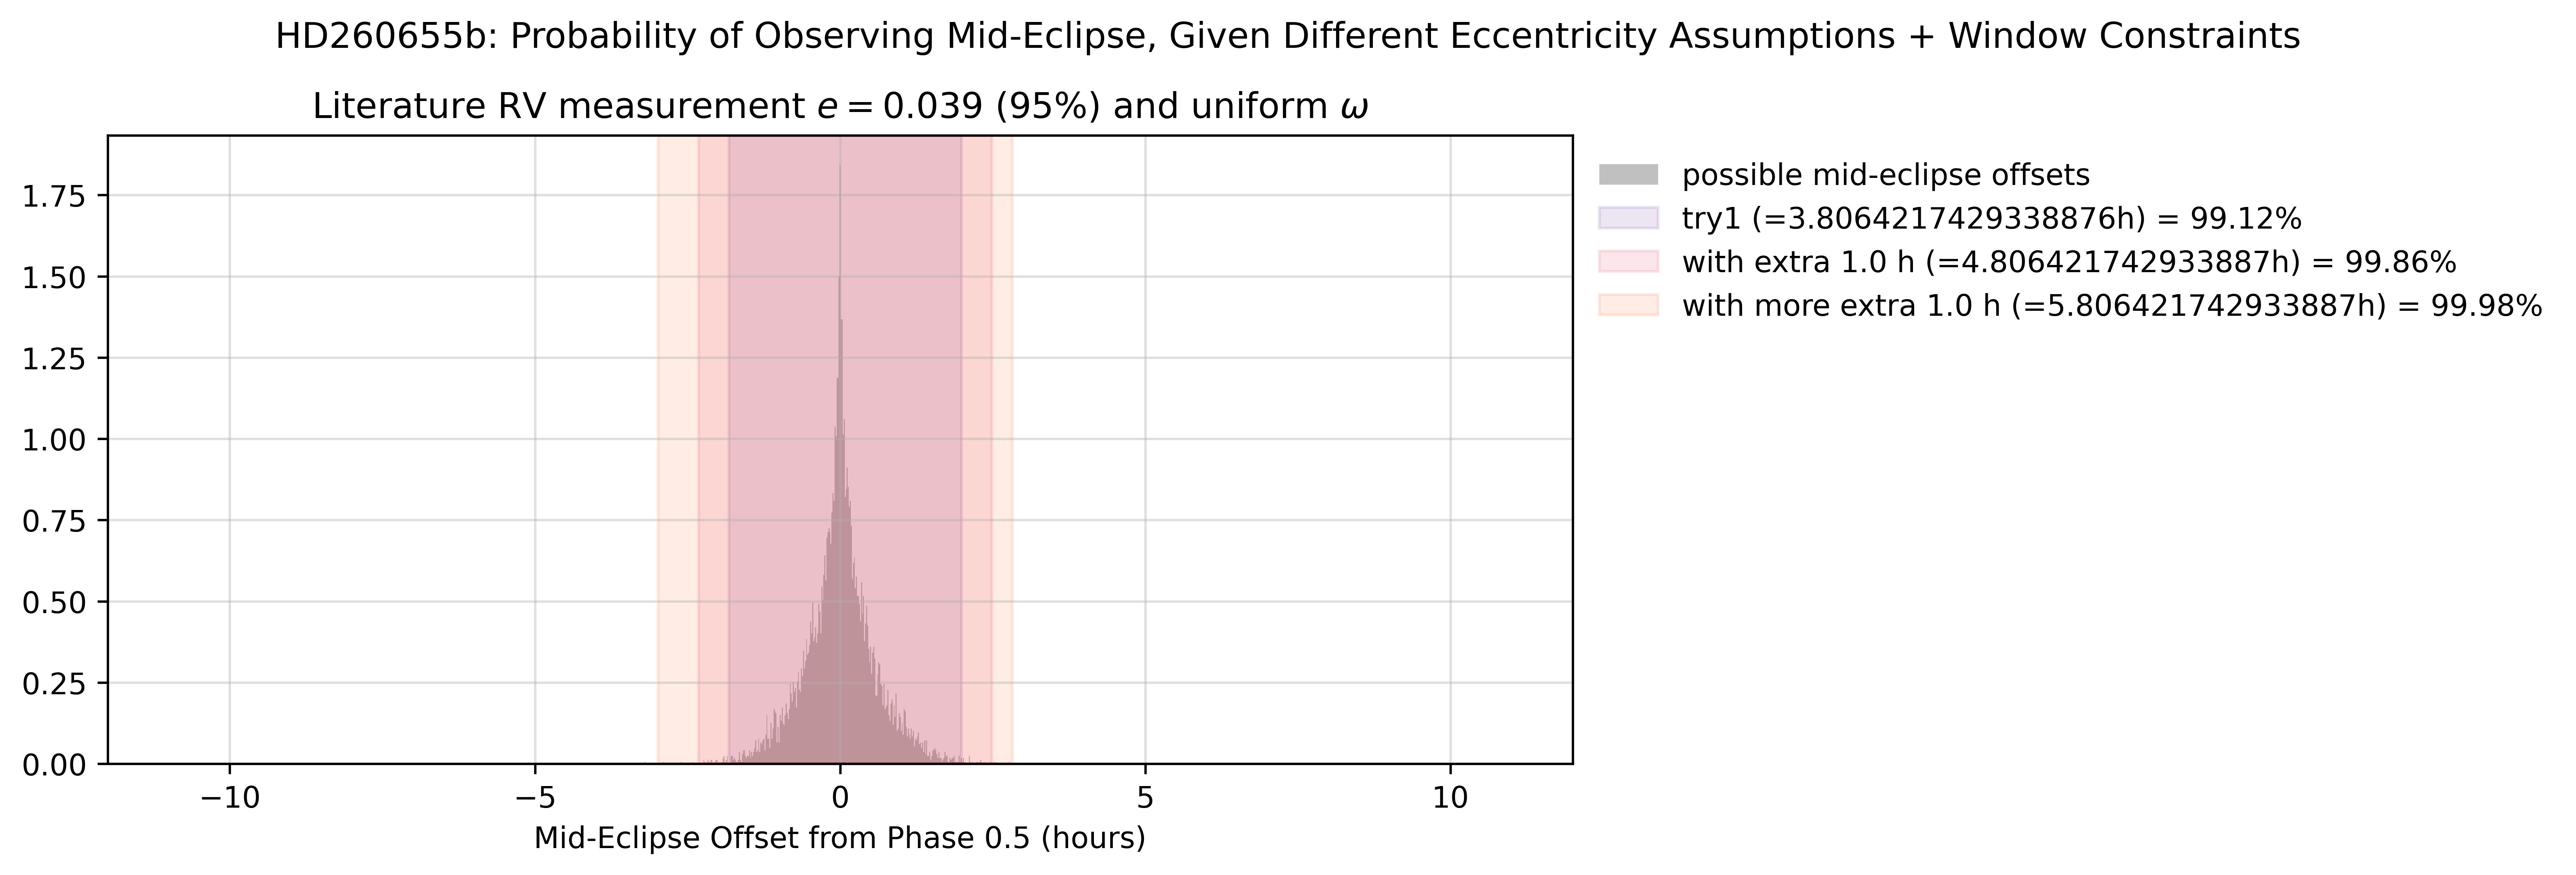

L 98-59 c P = 3.6906777 days ecc = 0.05
The uncertainty on predicted transit times in 2024 = 1.6173022975147566 minutes
event duration: 0.975153283961953 h
padding baseline for orbital period >2 days and ecc >= 0.05/ Tfrac=1.2

                   With the assumption of ''Literature RV measurement $e=0.05$ (95%) and uniform $\omega$', 
                   and the 'try1' observing window option, 
                   The best offset from exactly 0.5 phase is 0.08 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 92.20%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 91.37% +/- 0.73%
                   

                   With the assumption of ''Literature RV measurement $e=0.05$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
                   

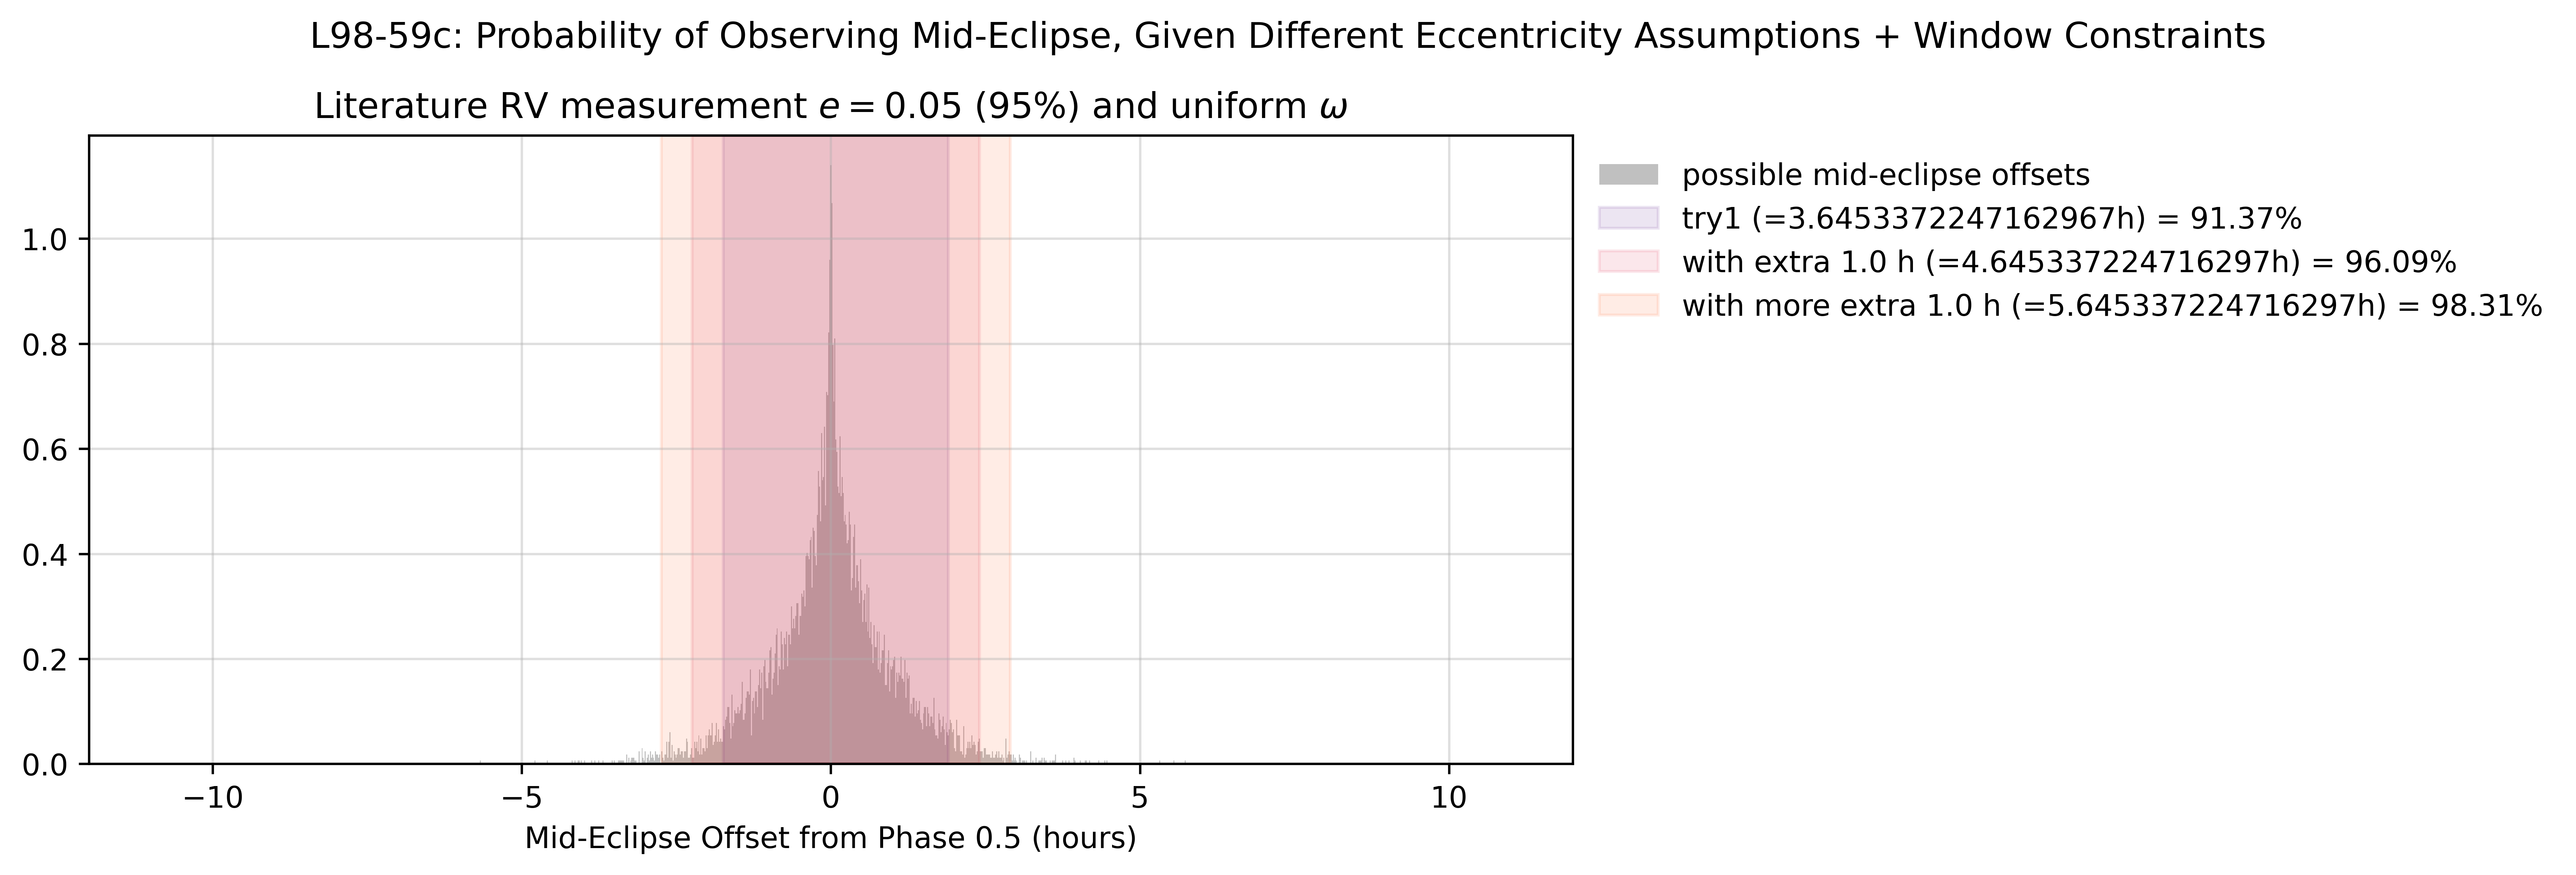

LHS 1140 c P = 3.777939728 days ecc = 0.068
The uncertainty on predicted transit times in 2024 = 4.339788867931592 minutes
event duration: 1.0829232789985161 h
padding baseline for orbital period >3 days and ecc >= 0.05/ Tfrac=2

                   With the assumption of ''Literature RV measurement $e=0.068$ (95%) and uniform $\omega$', 
                   and the 'try1' observing window option, 
                   The best offset from exactly 0.5 phase is -0.08 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 90.37%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 89.97% +/- 0.40%
                   

                   With the assumption of ''Literature RV measurement $e=0.068$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
              

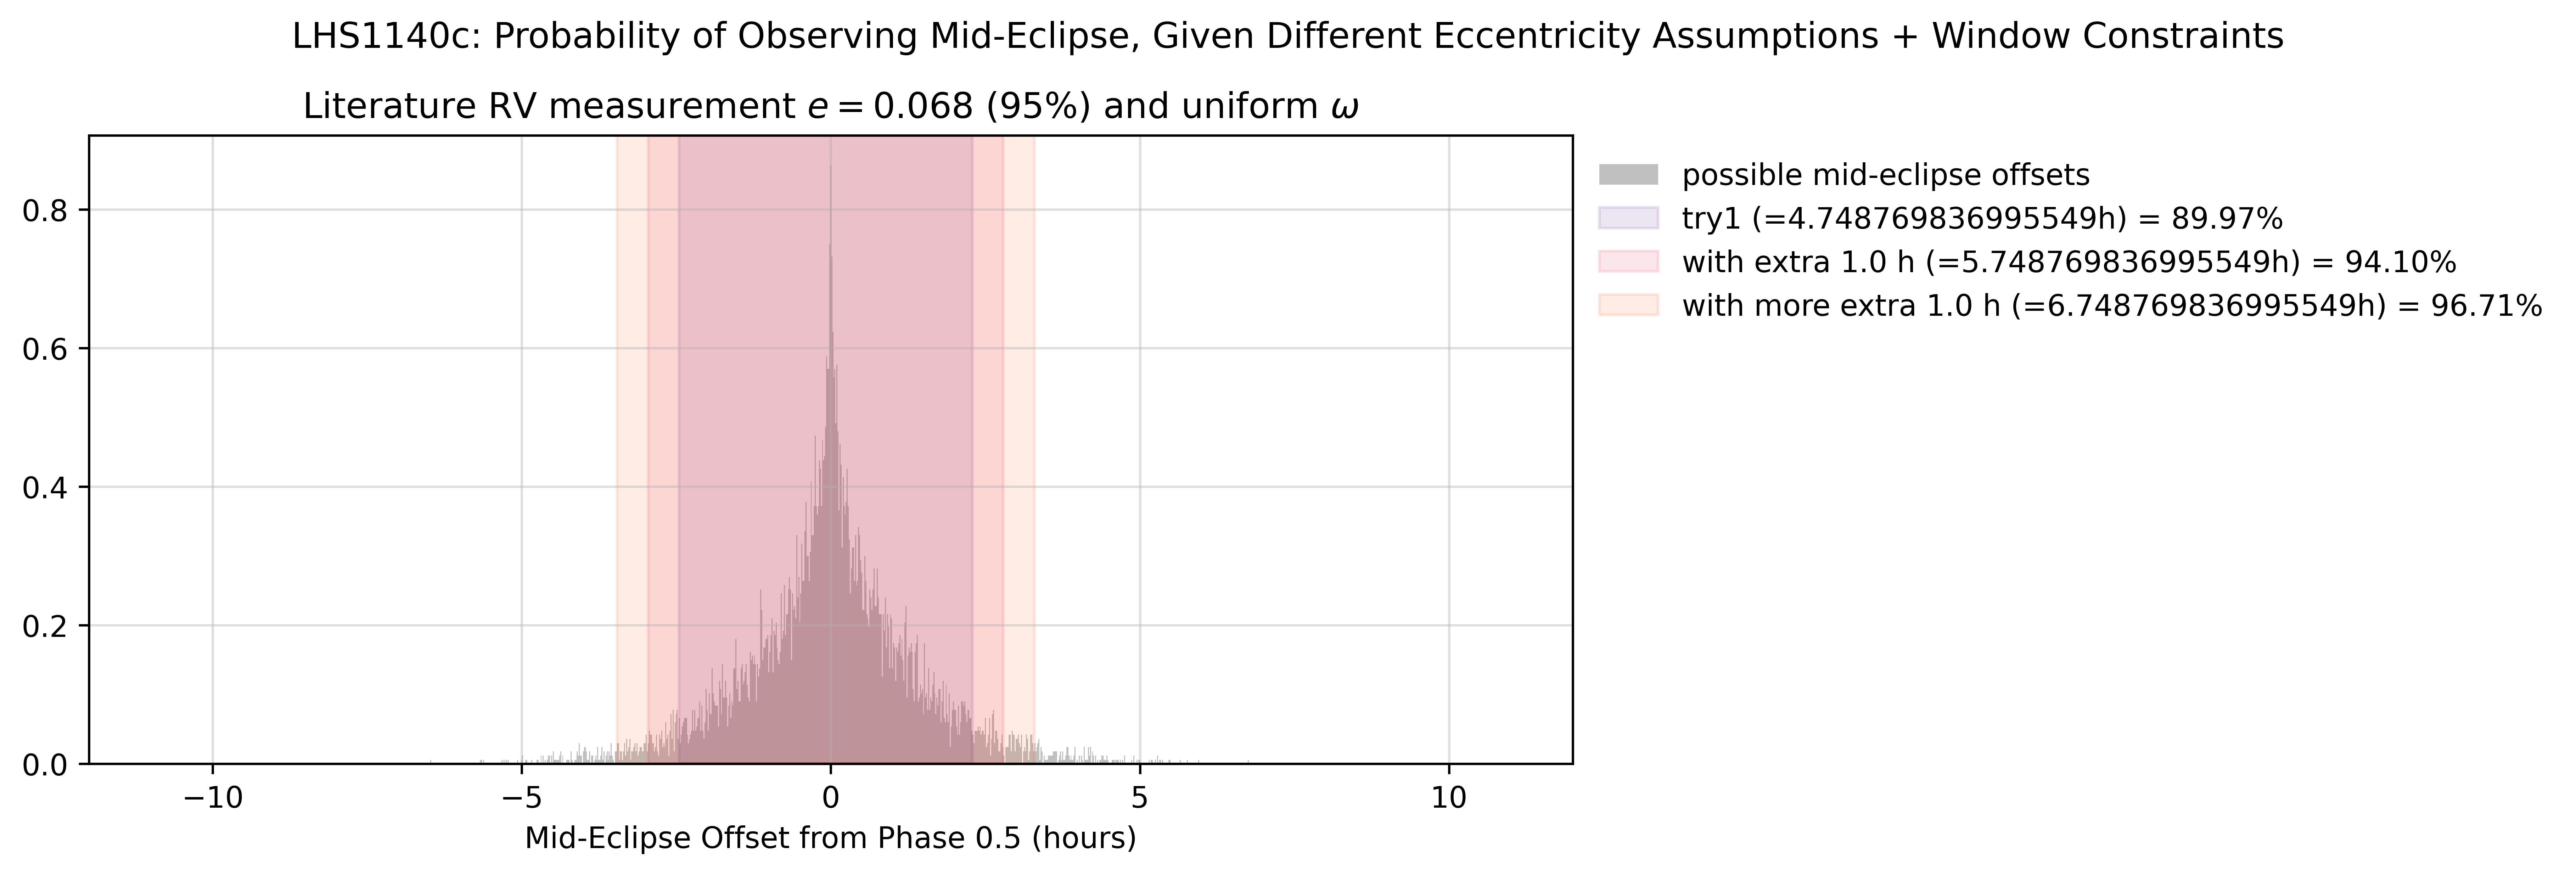

LHS 1478 b P = 1.9495378 days ecc = 0.1
The uncertainty on predicted transit times in 2024 = 4.551722137454993 minutes
event duration: 0.7230311073763287 h
padding baseline for orbital period >2 days and ecc >= 0.05/ Tfrac=1.2

                   With the assumption of ''Literature RV measurement $e=0.1$ (95%) and uniform $\omega$', 
                   and the 'try1' observing window option, 
                   The best offset from exactly 0.5 phase is 0.08 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 85.44%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 84.51% +/- 0.97%
                   

                   With the assumption of ''Literature RV measurement $e=0.1$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
                   Th

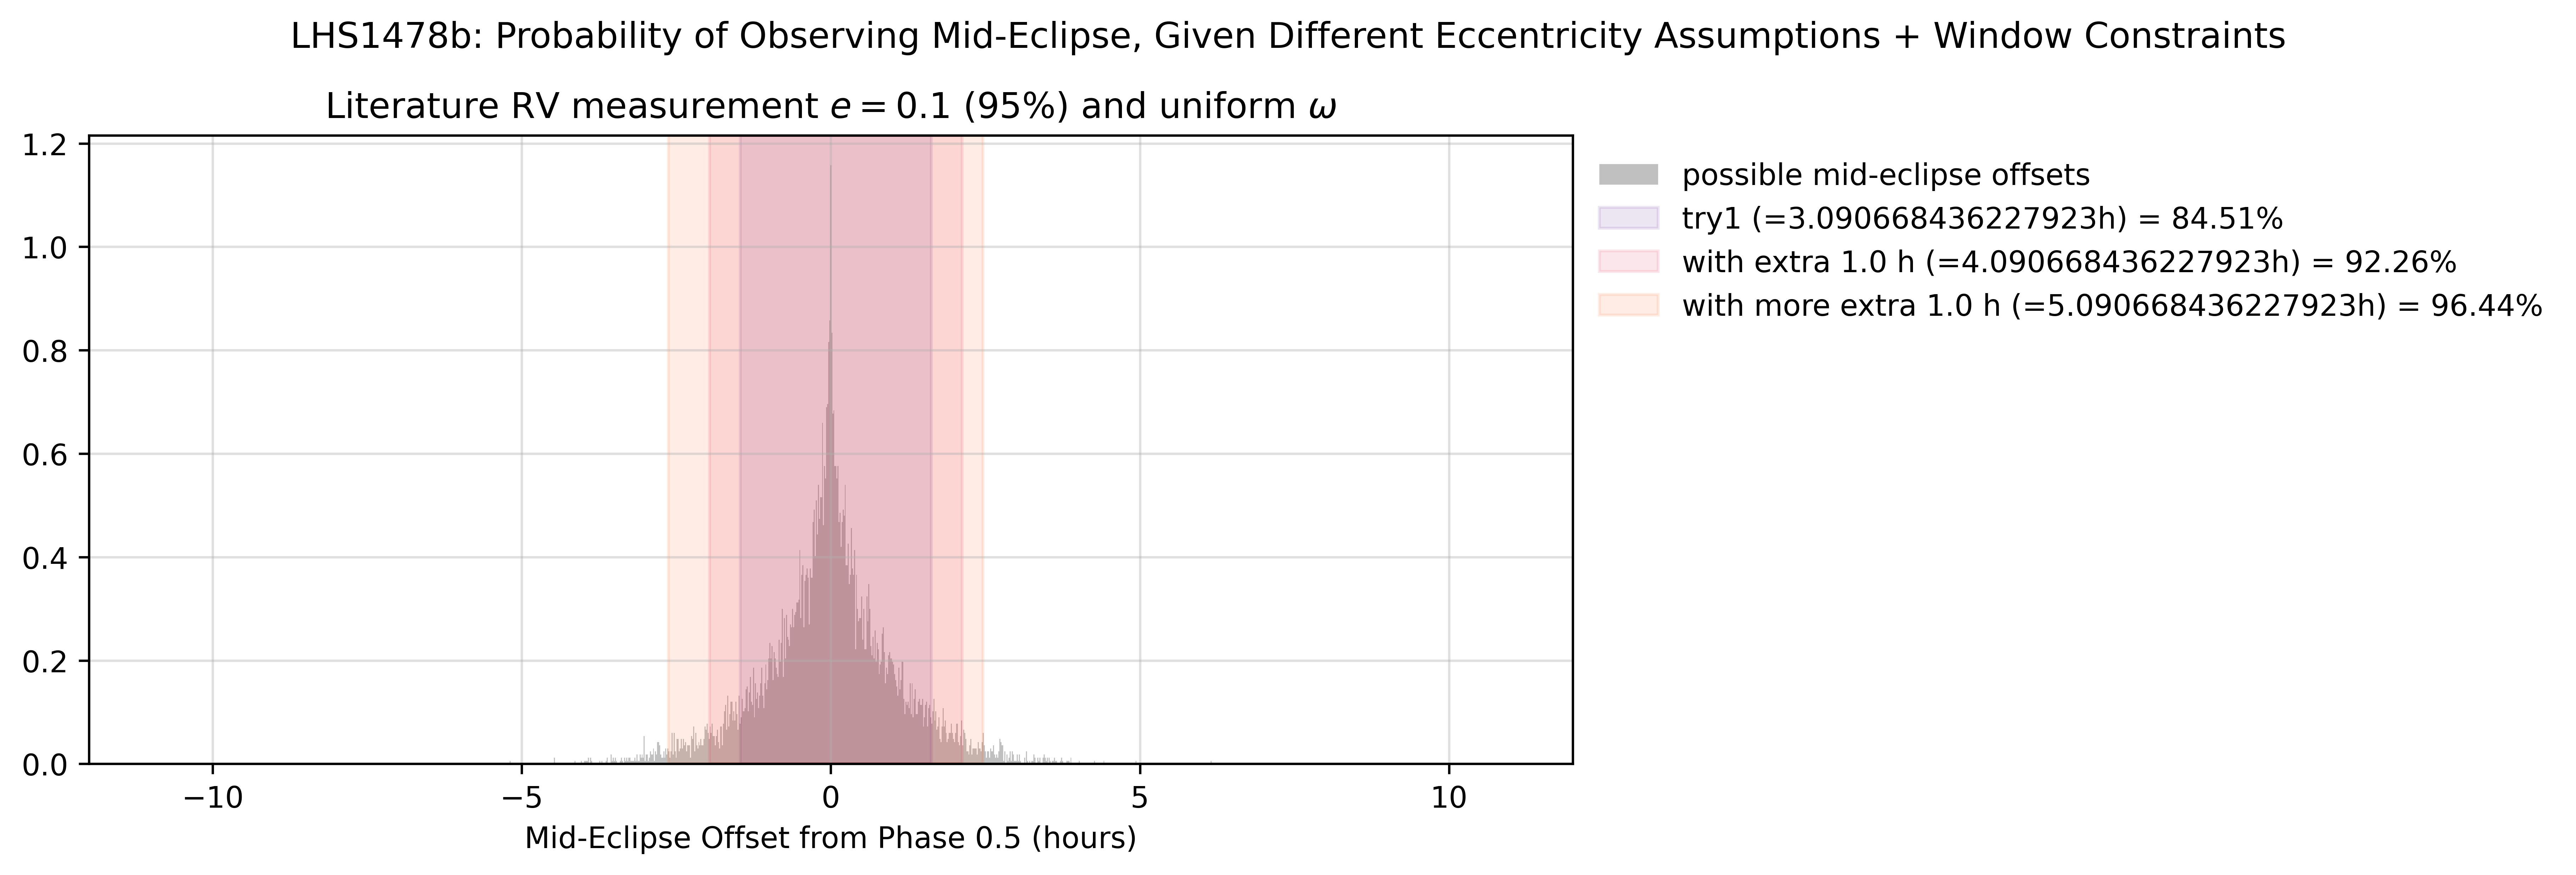

LTT 3780 b P = 0.768377 days ecc = 0.064
The uncertainty on predicted transit times in 2024 = 4.6774610475471325 minutes
event duration: 0.7628030950677402 h

                   With the assumption of ''Literature RV measurement $e=0.064$ (95%) and uniform $\omega$', 
                   and the 'try1' observing window option, 
                   The best offset from exactly 0.5 phase is -0.08 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 100.00%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 99.99% +/- 0.03%
                   

                   With the assumption of ''Literature RV measurement $e=0.064$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
                   The best offset from exactly 0.5 phase is -0.57 hours.
          

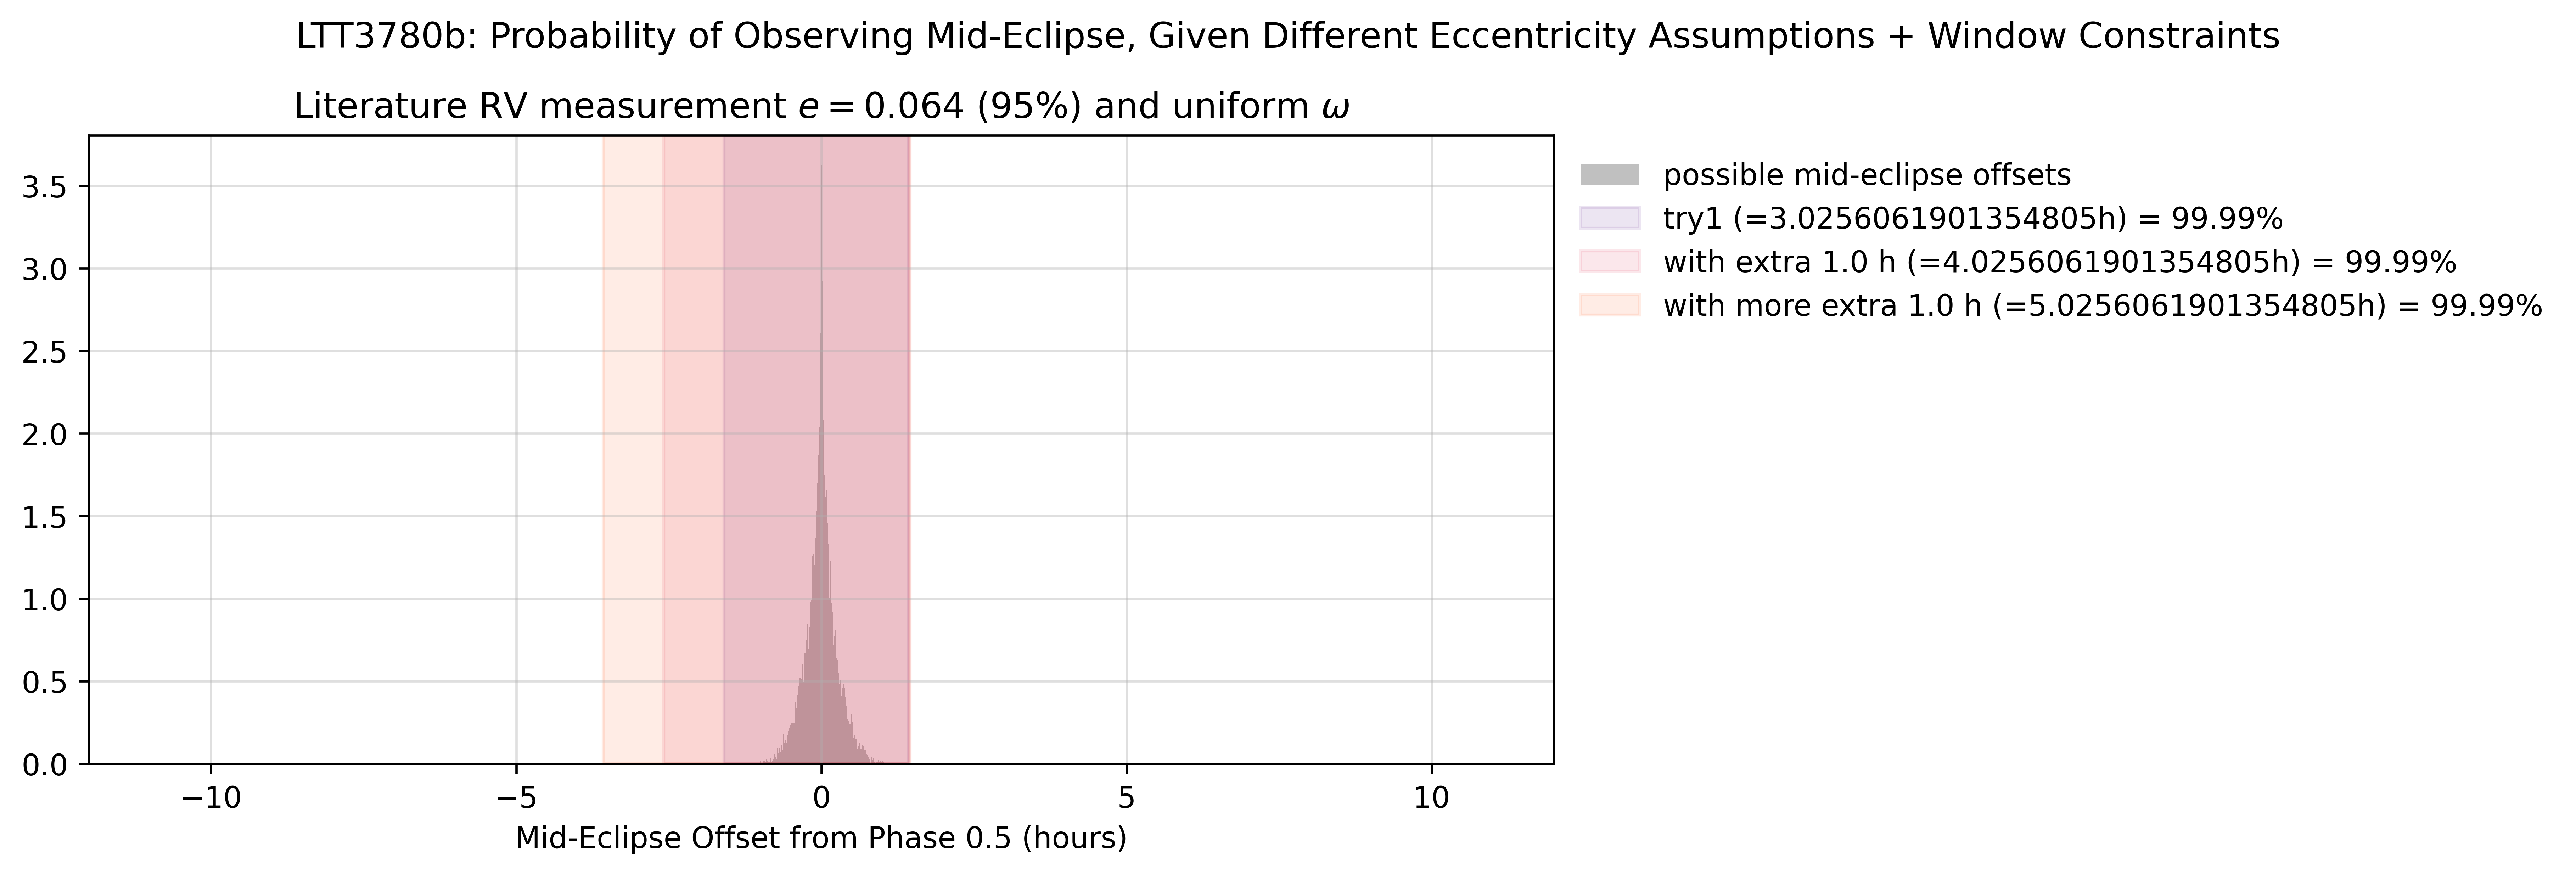

TOI-1468 b P = 1.8805136 days ecc = 0.1
The uncertainty on predicted transit times in 2024 = 3.093246079058635 minutes
event duration: 1.0513350608366205 h
padding baseline for orbital period >2 days and ecc >= 0.05/ Tfrac=1.2

                   With the assumption of ''Literature RV measurement $e=0.1$ (95%) and uniform $\omega$', 
                   and the 'try1' observing window option, 
                   The best offset from exactly 0.5 phase is -0.08 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 92.34%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 91.63% +/- 0.60%
                   

                   With the assumption of ''Literature RV measurement $e=0.1$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
                   T

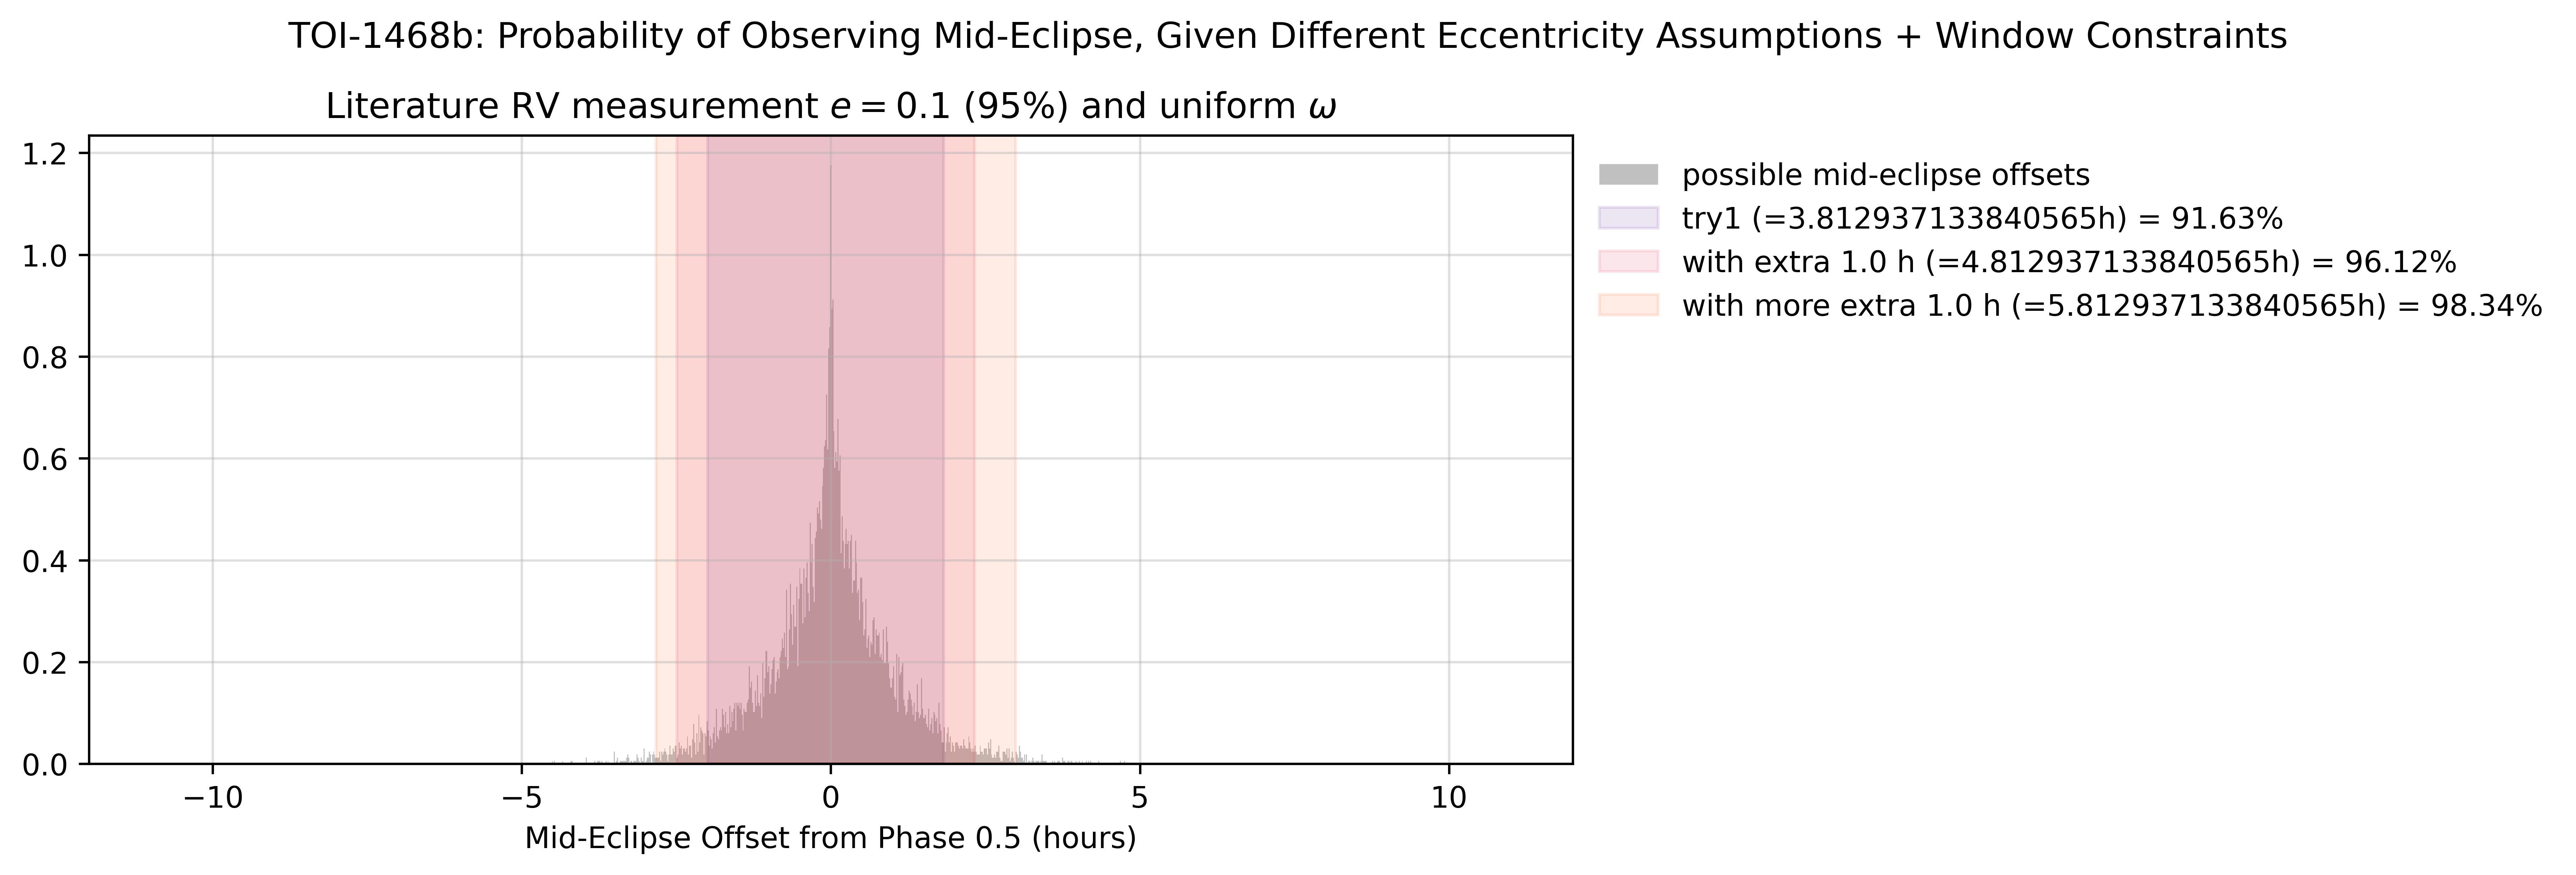

TOI-270 b P = 3.3601538 days ecc = 0.0167
The uncertainty on predicted transit times in 2024 = 4.0407400299398315 minutes
event duration: 1.4352326467008267 h

                   With the assumption of ''Literature RV measurement $e=0.0167$ (95%) and uniform $\omega$', 
                   and the 'try1' observing window option, 
                   The best offset from exactly 0.5 phase is -0.57 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 100.00%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 99.99% +/- 0.02%
                   

                   With the assumption of ''Literature RV measurement $e=0.0167$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
                   The best offset from exactly 0.5 phase is -1.06 hours.
       

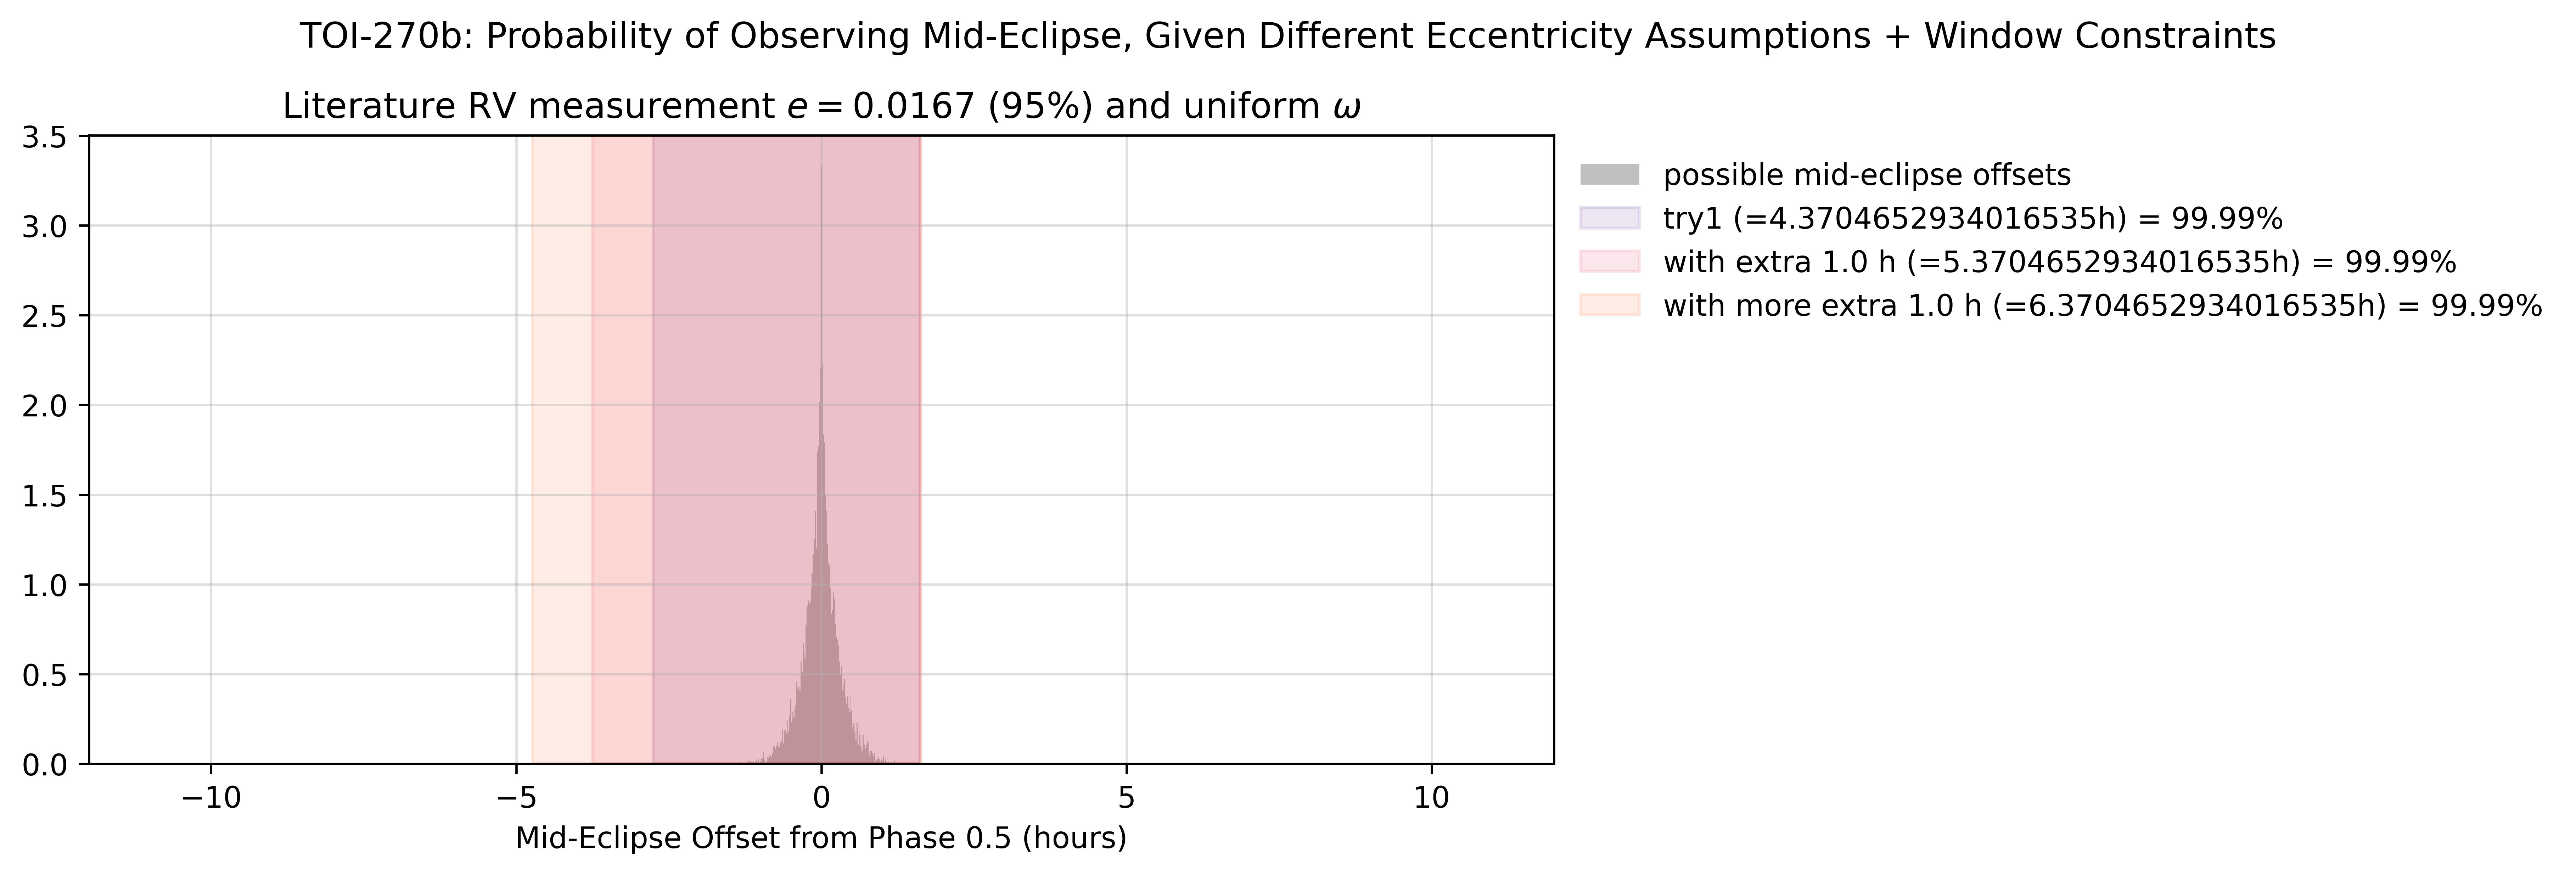

In [9]:
for targ in sample:
    #if targ['pl_orbeccen'] == 0.0: targ['pl_orbeccen'] = 0.05
    print(targ['pl_name'], 'P =', targ['pl_orbper'], 'days', 'ecc =', targ['pl_orbeccen'])
    assumptions = calc_eclipse_timing(targ)
    windows = calc_window(targ)
    make_eclipse_timing_fig(targ['pl_name'].replace(" ", ""), assumptions, windows)

!! need to adjust based on skewed uncertainty in eccentricity; don't have distribution so need to measure one side, then the other... then make sure to add each to the correct side

## Calcualte APT phase constraints

In [10]:
def calc_APT_phase(targ, Tfrac=1, Textra=0*u.hr, gamble=False):
    # if gamble: we will but 15 minutes of the 1 hour charge time *after* the event
    # the scheduler seems to always start the observations as early as possible so this will even out the baseline
    # however the scheduler makes no guarantees, so this is a gamle ;)
    # Tfraf =  fraction of time of out-of-event/in-event; e.g., for equal OOT to in-transit, tfrac=1
    # Textra = add some extra time to be added to the baseline in equal amounts on either side of the event
    
    # EDIT THE FOLLOWING PARAMETERS AS NECESSARY
    
    print(targ['pl_name'])
    tdur = orb.Tdur(P=targ['pl_orbper']*u.day, 
            Rp_Rs=((targ['pl_rade']*u.R_earth)/(targ['st_rad']*u.R_sun)).decompose(),
            a_Rs = ((targ['pl_orbsmax']*u.AU)/(targ['st_rad']*u.R_sun)).decompose(),
            i = targ['pl_orbincl']
           ) # event duration


    # if transit duration < 1 hour, automatically add a little baseline to bring it up to 1 hr; 
    # COMMMENT OUT IF YOU DO NOT WANT THIS FEATURE
    #if tdur.to(u.min).value < 60:
    #    Tfrac = ((1*u.hr)/(tdur.to(u.hr))).decompose()
    #    print(f'   padding baseline for shorter transit/ Tfrac={Tfrac}')
    if targ['pl_orbper'] > 3 and targ['pl_orbeccen'] > 0.05:
        # worst case scenario
        Tfrac = 2
        print(f'   padding baseline for orbital period >3 days and ecc >= 0.1/ Tfrac={Tfrac}')
    elif targ['pl_orbper'] > 1.5 and targ['pl_orbeccen'] >= 0.05:
        Tfrac = 1.5
        print(f'   padding baseline for orbital period >2 days and ecc >= 0.1/ Tfrac={Tfrac}')  
    #if targ['pl_orbeccen'] >= 0.1:
    #    Tfrac = 1.5
    #    print(f'   padding baseline for large or uncertain ecc/ Tfrac={Tfrac}')
    # Dwell time of the detector in minutes, in case there is a weird ramp like with HST
    Tdwell = 30 * u.min   # 30 minutes recommended for MIRI
    # charge yourself an hour of time since you'll get charged this anyway if your window is too small (<1 hr)
    Tcharge = 1.000001 * u.hr
    # extra time you might want... perhaps to ensure you catch a secondary eclipse or whatever
    if Textra.value > 0: print(f'   Adding {Textra} because of uncertain eclipse time')
    
    # T_14 in hours
    Tdur = tdur.to(u.hr)              # [hr]
    # Period in days
    P = targ['pl_orbper'] * u.day
    # T0; this is a time of mid-transit when phase=0 (does not have to be for a specific transit)
    T0 = targ['pl_tranmid']                # BJD-TDB
    # as a string, the RA and Dec of the host star, e.g., RA_Dec= '17:15:18.92 +04:57:50.1'
    RA_Dec = sys_coords = targ['rastr']+' '+targ['decstr']
    # do you want to observe a transit or an occultation (secondary eclsipse)
    obs_type = 'occ'                  # if secondary eclipse (occultation): 'occ', if transit: 'tra'

    #############################################################################################################
    ######### magical code; please don't touch ##################################################################
    #############################################################################################################

    #baseline = np.maximum((Tfrac*Tdur).to(u.hr).value, (Tdur/2).to(u.hr).value) * u.hr  # suggested pre- and post-eclipse baseline; you can tweak this if you really want
    baseline = (Tfrac*Tdur).to(u.hr) + Textra # total time out of transit/eclipse

    if   obs_type == 'tra': phase_midpoint = 0.0
    elif obs_type == 'occ': phase_midpoint = 0.5

    obs_start = Tdur/2 + baseline/2  # time before the event mid-point to start observing

    phase_max = phase_midpoint - (obs_start/P).decompose() - (Tdwell/P).decompose()
    phase_min = phase_max - (Tcharge/P).decompose()

    if gamble: 
        print('   Gambling to take 15 mins before the event and stick it after (becuase observing windows seem to start on time)')
        phase_max += (15*u.min/P).decompose()
        phase_min += (15*u.min/P).decompose()

    # code shamelessly stolen from: https://gist.github.com/StuartLittlefair/4ab7bb8cf21862e250be8cb25f72bb7a
    # converts bjd_tdb to heliocentric times; need this for JWST APT
    def bary_to_helio(star, bjd, obs_name):
        bary = Time(bjd, scale='tdb', format='jd')
        obs = EarthLocation.of_site(obs_name)
        #star = SkyCoord(coords, unit=(u.hour, u.deg))
        ltt = bary.light_travel_time(star, 'barycentric', location=obs) 
        guess = bary - ltt
        delta = (guess + guess.light_travel_time(star, 'barycentric', obs)).jd  - bary.jd
        guess -= delta * u.d

        ltt = guess.light_travel_time(star, 'heliocentric', obs)
        return guess.utc + ltt

    phase0 = Time(T0, format='jd', scale='tdb')
    star = SkyCoord(RA_Dec, unit=(u.hourangle, u.deg))
    random_earth_place_name = 'lco'

    phase0_hjd = bary_to_helio(star, phase0, random_earth_place_name)

    print('   ****** PHASE *******')
    print('   Phase range {} to {}'.format(phase_min, phase_max))
    print('   Period {}'.format(P))
    print('   Zero phase (HJD) {}'.format(phase0_hjd))
    print('')


    total_time = (Tdwell + baseline + Tdur + Tcharge).to(u.hr)

    print('   *** ESTIMATED TOTAL TIME ***')
    print('   NOTE: This does not go into the APT, it is just an estimate')
    print('   Event duration {}'.format(Tdur.to(u.min)))
    print('   TOTAL TIME PER OBSERVATION: {}'.format(total_time))
    print('')
    
    
    return total_time

In [11]:
def calc_integrations_per_exposure(ngroup, total_time, subarray):

    if   subarray.lower()=='full':      tframe = 2.77504 * u.s
    elif subarray.lower()=='brightsky': tframe = 0.86528 * u.s
    elif subarray.lower()=='sub256':    tframe = 0.29952 * u.s
    elif subarray.lower()=='sub128':    tframe = 0.11904 * u.s
    elif subarray.lower()=='sub64':     tframe = 0.08500 * u.s
    else: 
        print('ERROR: subarray not recognized')
        return
    
    tint    = tframe * ngroup                         # amount of time per integration
    treset  = 1*tframe                                # reset time between each integration
    cadence = tint + treset
    
    nintegrations = int(np.ceil((total_time/cadence).decompose()))
    print('    ***** FORM EDITOR ******')
    print(f'   subarray = {subarray}')
    print(f'   Ngroups {ngroup}')
    print(f'   Integrations/exposer {nintegrations}')
    
    return nintegrations

In [12]:
total_times = 0*u.hr
for i in range(len(sample)):
    if i in [1, 5]: Textra = 1*u.hr
    #elif i in [1, 4]: Textra = 2*u.hr
    #if i in [1, 4, 5]: Textra = 1*u.hr #to get everything into >90% confidence of catching
    else: Textra = 0*u.hr
    total_time = calc_APT_phase(sample[i], Tfrac=1, Textra=Textra, gamble=True)
    nintegrations = calc_integrations_per_exposure(sample[i]['ngroup'], total_time, subarray=sample[i]['subarray'])
    total_times += total_time*sample[i]['nobs']

GJ 3473 b
   Gambling to take 15 mins before the event and stick it after (becuase observing windows seem to start on time)
   ****** PHASE *******
   Phase range 0.42375572952391305 to 0.45853583807853965
   Period 1.198003975976397 d
   Zero phase (HJD) 2458492.203283507

   *** ESTIMATED TOTAL TIME ***
   NOTE: This does not go into the APT, it is just an estimate
   Event duration 56.53089241311159 min
   TOTAL TIME PER OBSERVATION: 3.3843640804370527 h

    ***** FORM EDITOR ******
   subarray = sub256
   Ngroups 39
   Integrations/exposer 1017
GJ 357 b
   padding baseline for orbital period >3 days and ecc >= 0.1/ Tfrac=2
   Adding 1.0 h because of uncertain eclipse time
   Gambling to take 15 mins before the event and stick it after (becuase observing windows seem to start on time)
   ****** PHASE *******
   Phase range 0.460403410090591 to 0.47100399046910213
   Period 3.9306063296116895 d
   Zero phase (HJD) 2458517.9978584545

   *** ESTIMATED TOTAL TIME ***
   NOTE: This doe

In [13]:
total_times

<Quantity 90.33840371 h>

In [14]:
sample[1]

hostname,pl_name,sy_dist,rastr,decstr,sy_kmag,st_mass,st_rad,st_raderr1,st_raderr2,st_teff,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbsmax,pl_orbincl,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,tran_flag,rv_flag,pl_rp_rs,pl_g,pl_teq_a0,pl_s,pl_rho,filter,subarray,nobs,ngroup,frac_fullwell,pl_ecosw,pl_ecoswerr
str9,str11,float64,str12,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,str6,str6,int64,int64,float64,float64,float64
GJ 357,GJ 357 b,9.44181,09h36m01.79s,-21d39m54.23s,6.475,0.34,0.34,0.02,-0.02,3505.0,2458517.998679131,0.0003765,-0.0003765,1.217,0.084,-0.083,1.84,0.31,-0.31,3.9306063296116895,1.16151077e-06,-1.16151077e-06,0.035,89.12,0.09,--,--,1,1,0.03281564780289002,12.17283537042799,526.7769415618036,12.786873373040743,5.609388414817885,f1500w,sub64,1,22,0.85,0.0,0.05
